In [ ]:
# Import Required Libraries
import pandas as pd
pd.set_option('display.max_columns', 20)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('universal_tagset')
import string
import gensim.downloader as api
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [3]:
# Mount Google Drive to access files in Google Colab
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [4]:
# Read the data from a csv file
df = pd.read_csv('/content/drive/MyDrive/chunk6.csv')

# Display the first few rows
df.head()

,article,summary
0,Atlanta (CNN)The breakup of a gun smuggling ri...,"""This is an important wake-up call,"" analyst s..."
1,"By . Steve Nolan . PUBLISHED: . 12:39 EST, 29 ...",Princeton University studied the emotion known...
2,(CNN) -- Members of the international communi...,U.S. Vice President Joe Biden: Questions need ...
3,John Carver has told Newcastle’s hierarchy the...,Moussa Sissoko cost Newcastle £1.5million from...
4,By . Daily Mail Reporter . PUBLISHED: . 16:24 ...,"The Dow Jones closed at 14,758 points on Thurs..."


In [5]:
# Display information about the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   article  20000 non-null  object
 1   summary  20000 non-null  object
dtypes: object(2)
memory usage: 312.6+ KB


In [6]:
# Check for missing values
df.isnull().sum()

article    0
summary    0
dtype: int64

In [7]:
# Check for duplicate rows
df.duplicated().sum()

15

In [8]:
# Drop duplicate rows
df.drop_duplicates(inplace=True)

# Check for duplicate rows again
df.duplicated().sum()

0

## Descriptive Statistics

In [9]:
# Display summary statistics
df.describe()

,article,summary
count,19985,19985
unique,19985,19966
top,Atlanta (CNN)The breakup of a gun smuggling ri...,The daily transcript is a written version of e...
freq,1,4


## Features Extraction

In [10]:
#helper funtion to count the number of stopwords
def count_stopwords(text, stopwords):
    """
    Count the number of stopwords in a given text.

    Args:
        text (str): The input text to analyze.
        stopwords (list): A list of stopwords.

    Returns:
        int: The count of stopwords in the text.
    """
    word_tokens = word_tokenize(text)
    stop_words = [word for word in word_tokens if word in stopwords]
    return len(stop_words)


In [11]:
#helper function to split a text into sentences
def split_sentences(text):
    """
    Split a text into sentences using NLTK's sentence tokenizer.

    Args:
        text (str): The input text to split.

    Returns:
        list: A list of sentences in the text.
    """
    sentences = nltk.sent_tokenize(text)
    return sentences

In [12]:
# define stopwords and punctuation
stopwords = stopwords.words('english')
punc = string.punctuation

# Count the number of sentences in 'article' and 'summary' columns
df['article_sentence_count'] = df['article'].apply(lambda x: len(split_sentences(x)))
df['summary_sentence_count'] = df['summary'].apply(lambda x: len(split_sentences(x)))

# Count the number of words in 'article' and 'summary' columns
df['article_word_count'] = df['article'].apply(lambda x: len(x.split()))
df['summary_word_count'] = df['summary'].apply(lambda x: len(x.split()))

# Count the number of characters (excluding spaces) in 'article' and 'summary' columns
df['article_char_count'] = df['article'].apply(lambda x: len(x.replace(" ", "")))
df['summary_char_count'] = df['summary'].apply(lambda x: len(x.replace(" ", "")))

# Calculate word density (words per character) in 'article' and 'summary' columns
df['article_word_density'] = df['article_word_count'] / (df['article_char_count'] + 1)
df['summary_word_density'] = df['summary_word_count'] / (df['summary_char_count'] + 1)

# Calculate sentence density (sentences per word) in 'article' and 'summary' columns
df['article_sentence_density'] = df['article_sentence_count'] / (df['article_word_count'] + 1)
df['summary_sentence_density'] = df['summary_sentence_count'] / (df['summary_word_count'] + 1)

# Count the number of punctuation marks in 'article' and 'summary' columns
df['article_punctuation_count'] = df['article'].apply(lambda x: len([a for a in x if a in punc]))
df['summary_punctuation_count'] = df['summary'].apply(lambda x: len([a for a in x if a in punc]))

# Count the number of stopwords in 'article' and 'summary' columns
df['article_stopwords_count'] = df['article'].apply(lambda x: count_stopwords(x, stopwords))
df['summary_stopwords_count'] = df['summary'].apply(lambda x: count_stopwords(x, stopwords))

# Calculate stopwords density (stopwords per word) in 'article' and 'summary' columns
df['article_stopwords_density'] = df['article_stopwords_count'] / (df['article_word_count'] + 1)
df['summary_stopwords_density'] = df['summary_stopwords_count'] / (df['summary_word_count'] + 1)

df.head()

,article,summary,article_sentence_count,summary_sentence_count,article_word_count,summary_word_count,article_char_count,summary_char_count,article_word_density,summary_word_density,article_sentence_density,summary_sentence_density,article_punctuation_count,summary_punctuation_count,article_stopwords_count,summary_stopwords_count,article_stopwords_density,summary_stopwords_density
0,Atlanta (CNN)The breakup of a gun smuggling ri...,"""This is an important wake-up call,"" analyst s...",64,4,1141,58,5941,291,0.192023,0.198630,0.056042,0.067797,235,12,422,19,0.369527,0.322034
1,"By . Steve Nolan . PUBLISHED: . 12:39 EST, 29 ...",Princeton University studied the emotion known...,41,1,697,20,3519,119,0.198011,0.166667,0.058739,0.047619,145,4,263,5,0.376791,0.238095
2,(CNN) -- Members of the international communi...,U.S. Vice President Joe Biden: Questions need ...,32,4,707,49,3932,259,0.179761,0.188462,0.045198,0.080000,118,12,267,10,0.377119,0.200000
3,John Carver has told Newcastle’s hierarchy the...,Moussa Sissoko cost Newcastle £1.5million from...,24,4,544,48,2563,236,0.212168,0.202532,0.044037,0.081633,66,7,240,16,0.440367,0.326531
4,By . Daily Mail Reporter . PUBLISHED: . 16:24 ...,"The Dow Jones closed at 14,758 points on Thurs...",43,3,616,33,2863,155,0.215084,0.211538,0.069692,0.088235,142,5,178,9,0.288493,0.264706


## Analyze Feature Distributions on the article variable

In [13]:
# Select columns related to article
article_columns = df[['article_sentence_count', 'article_word_count', 'article_char_count',
                             'article_word_density', 'article_sentence_density',
                             'article_punctuation_count', 'article_stopwords_count']]

# descriptive statistics for the article columns
article_columns.describe()

,article_sentence_count,article_word_count,article_char_count,article_word_density,article_sentence_density,article_punctuation_count,article_stopwords_count
count,19985.000000,19985.000000,19985.000000,19985.000000,19985.000000,19985.000000,19985.000000
mean,39.266150,694.685264,3356.476257,0.206960,0.055745,120.296622,269.663297
std,24.113572,341.836052,1648.092429,0.011192,0.015128,67.093846,138.730897
min,1.000000,21.000000,97.000000,0.054964,0.016871,6.000000,0.000000
25%,23.000000,442.000000,2135.000000,0.199262,0.045673,72.000000,167.000000
50%,33.000000,631.000000,3033.000000,0.206855,0.052441,105.000000,243.000000
75%,50.000000,882.000000,4260.000000,0.214399,0.062305,154.000000,347.000000
max,399.000000,2085.000000,10333.000000,0.267188,0.493849,850.000000,903.000000


### Summarizing:
- The mean number of sentences, words, and characters per row is 39, 694, and 3356, respectively. These values closely align with the median values, suggesting a relatively balanced distribution.
- The standard deviations for the number of sentences, words, and characters are quite large. This means that there is a wide variation in the values.
- The maximum number of sentences is 399 and the maximum number of characters is more than 10333. These values are far away from the mean values. This indicates that there are some rows that have values that are out of range or outliers.

In [14]:
# create helper functions to draw box plot and histograms
def plot_box_plots(data, columns, num_rows=2, num_cols=3):
    """
    Plot box plots for specified columns from a DataFrame.

    Args:
        data (DataFrame): The input DataFrame containing the columns to plot.
        columns (list): List of column names to create box plots for.
        num_rows (int): Number of rows for the subplot grid (default is 2).
        num_cols (int): Number of columns for the subplot grid (default is 3).

    Returns:
        None
    """

    # Calculate the total number of plots needed
    total_plots = num_rows * num_cols

    # Create a subplot grid to accommodate the specified number of columns
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(20, 4))
    axes = axes.flatten()

    # Plot box plots for each column in the specified list
    for i, col in enumerate(columns):
        if i < total_plots:
            ax = axes[i]
            ax.boxplot(data[col], vert=True)
            ax.set_title(col.replace("_", " "))
            ax.set_xlabel("Value")

    # Hide any remaining empty subplots (if there are fewer columns than total_plots)
    for i in range(len(columns), total_plots):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

def plot_histograms(data, num_rows=None, num_cols=None):
    """
    Plot histograms for each column in the DataFrame.

    Args:
        data (DataFrame): The input DataFrame containing columns to plot.
        num_rows (int): Number of rows for subplots (optional). If not provided,
                        it will be automatically calculated based on the number of columns.
        num_cols (int): Number of columns for subplots (optional). If not provided,
                        it will be automatically calculated based on the number of columns.

    Returns:
        None
    """
    # Get the column names from the DataFrame
    columns = data.columns

    # Calculate the number of rows and columns for the subplots
    if num_rows is None and num_cols is None:
        num_rows = int(len(columns) ** 0.5)
        num_cols = (len(columns) + num_rows - 1) // num_rows
    elif num_rows is None:
        num_rows = (len(columns) + num_cols - 1) // num_cols
    elif num_cols is None:
        num_cols = (len(columns) + num_rows - 1) // num_rows

    # Create subplots
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(20, 4))

    # Flatten the axes array to easily iterate over each subplot
    axes = axes.flatten()

    # Plot histograms for each column on the corresponding subplot
    for i, col in enumerate(columns):
        if i < len(columns):
            ax = axes[i]
            ax.hist(data[col], bins=100)
            ax.set_title(col.replace("_", " "))
            ax.set_xlabel("Value")
            ax.set_ylabel("Frequency")

    # Hide any remaining empty subplots
    for i in range(len(columns), num_rows * num_cols):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()


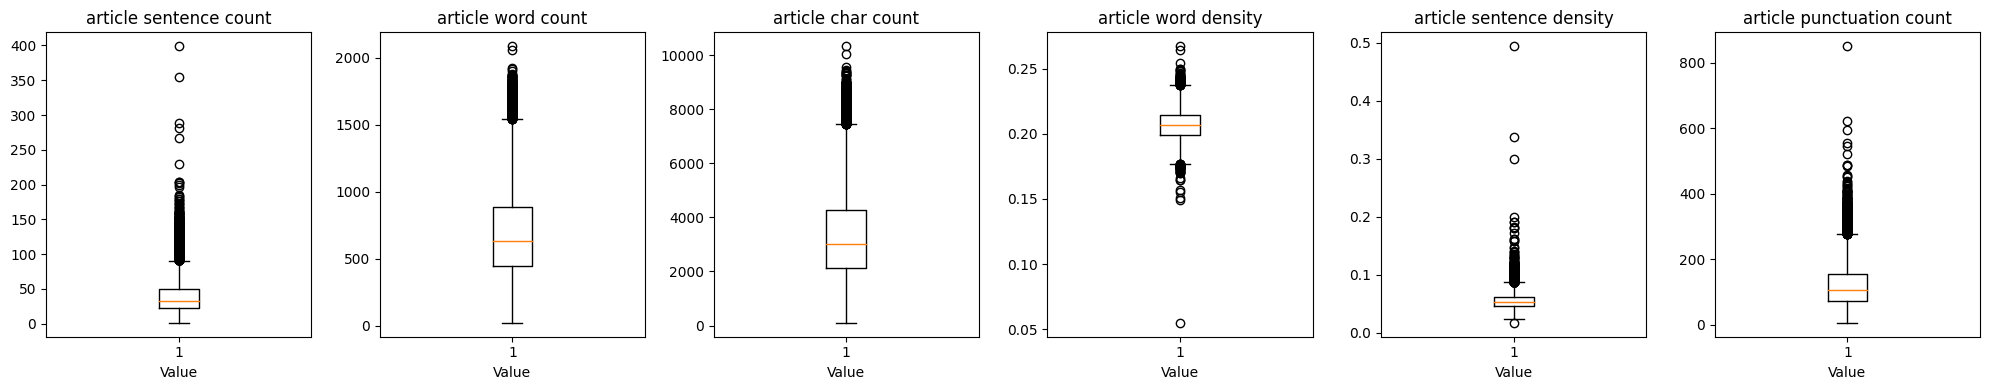

In [15]:
# select article related columns
article_columns_to_plot= ['article_sentence_count', 'article_word_count', 'article_char_count','article_word_density',
                          'article_sentence_density', 'article_punctuation_count', 'article_stopwords_count']
# box plot
plot_box_plots(df, article_columns_to_plot, num_rows=1, num_cols=6)

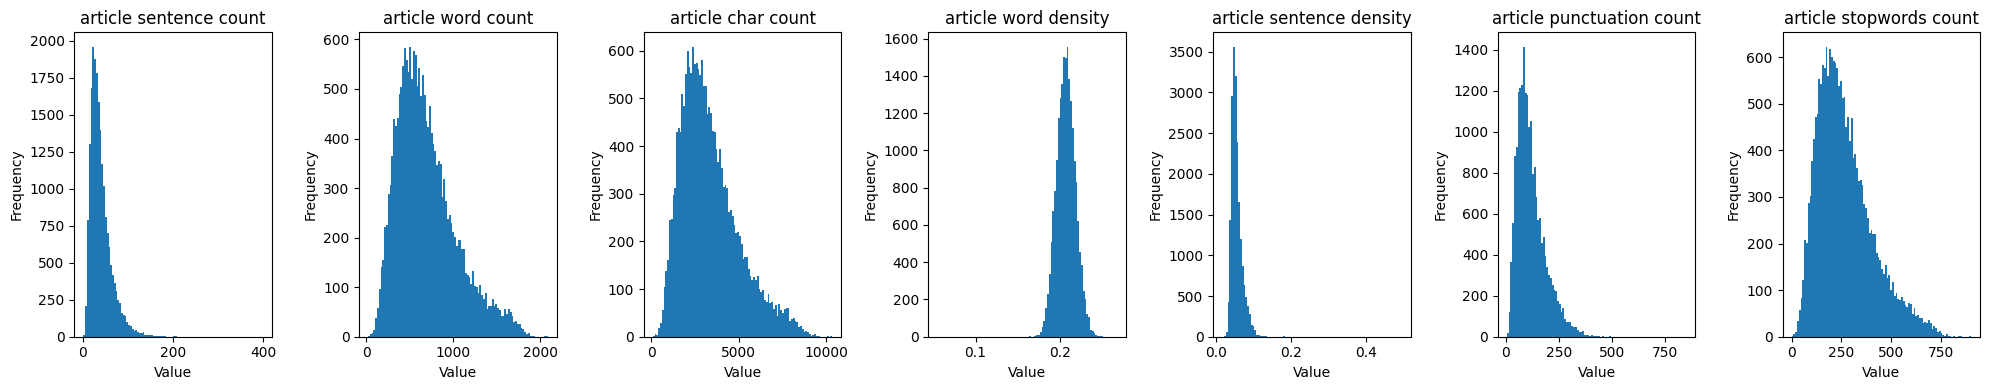

In [16]:
# plot histograms for the article columns
plot_histograms(article_columns, num_rows=1, num_cols=7)

### Summary:
- The data contains some data points that are not typical of the rest of the data. There are some articles in the data that have a significantly different number of sentences, words, characters, word density, sentence density, or punctuation count than the majority of the articles.
- The distribution of the number of sentences, punctuation marks, stopwords, and sentence density in the articles is skewed to the left.

## Analyze the Feature Distributions on the Summary Variable

In [17]:
# Select specific columns related to the 'summary'
summary_columns = df[['summary_sentence_count', 'summary_word_count', 'summary_char_count','summary_word_density',
                      'summary_sentence_density','summary_punctuation_count', 'summary_stopwords_count']]

# Generate descriptive statistics for the 'summary' columns
summary_columns.describe()

,summary_sentence_count,summary_word_count,summary_char_count,summary_word_density,summary_sentence_density,summary_punctuation_count,summary_stopwords_count
count,19985.000000,19985.000000,19985.000000,19985.000000,19985.000000,19985.000000,19985.000000
mean,3.695622,51.672004,247.677208,0.208015,0.072712,8.175732,15.839079
std,1.302970,20.818708,98.659752,0.017381,0.016237,4.210240,8.480924
min,1.000000,7.000000,38.000000,0.126984,0.011236,0.000000,0.000000
25%,3.000000,38.000000,183.000000,0.196491,0.062500,5.000000,10.000000
50%,4.000000,48.000000,235.000000,0.207792,0.073171,7.000000,14.000000
75%,4.000000,60.000000,287.000000,0.219355,0.081633,10.000000,19.000000
max,26.000000,388.000000,1845.000000,0.297030,0.181818,122.000000,154.000000


### Summarizing:
- The mean number of sentences, words, and characters per row is 3, 51, and 247, respectively.
- The standard deviations for the number of sentences is small.However the stds for words, and characters are quite large.
- The maximum number of sentences is 26 and the maximum number of characters is more than 1845. These values are far away from the mean values.

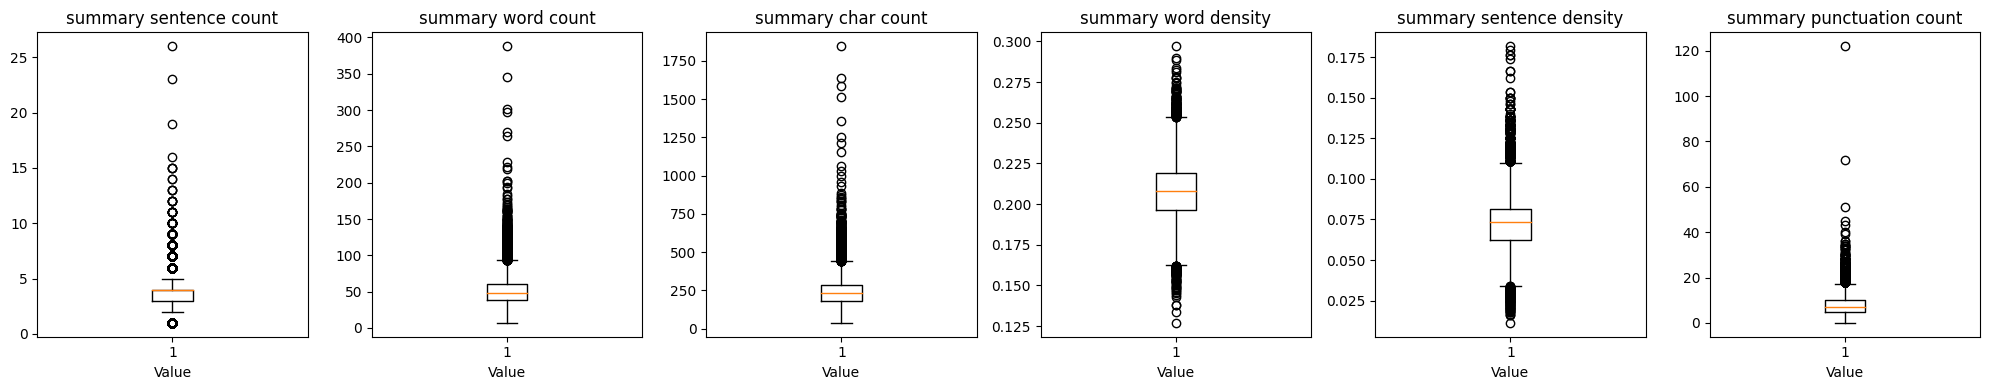

In [18]:
# select summary related columns
summary_columns_to_plot= ['summary_sentence_count', 'summary_word_count', 'summary_char_count','summary_word_density',
                          'summary_sentence_density', 'summary_punctuation_count', 'summary_stopwords_count']
# box plot
plot_box_plots(df, summary_columns_to_plot, num_rows=1, num_cols=6)

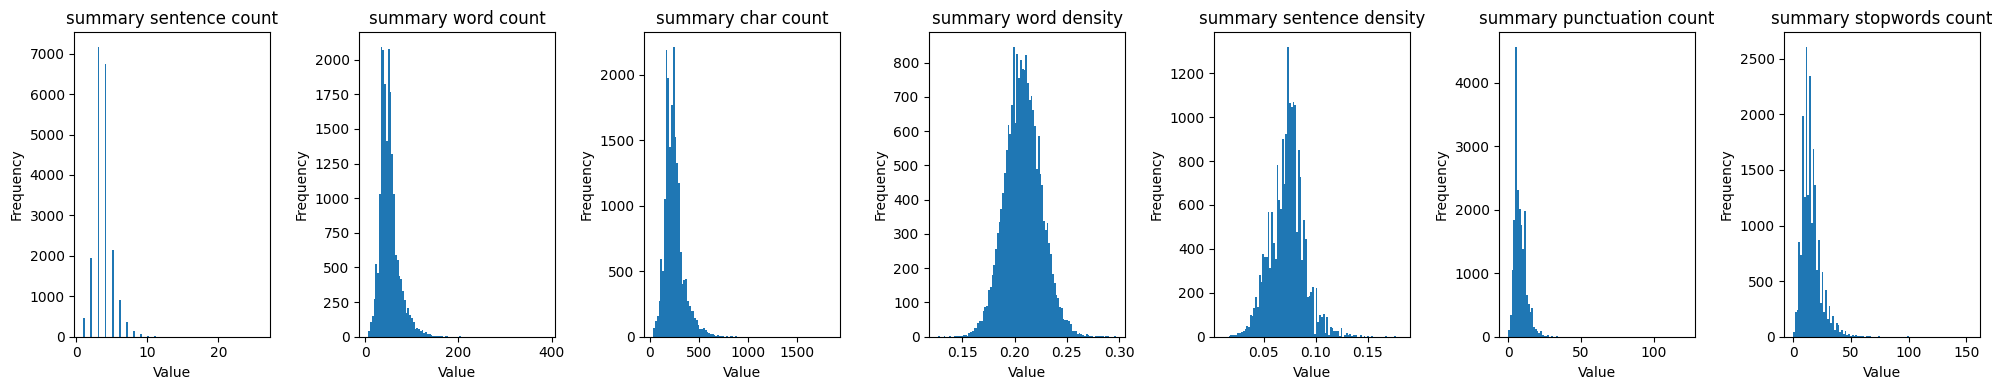

In [19]:
# plot histograms for the article columns
plot_histograms(summary_columns, num_rows=1, num_cols=7)

### Summary:
- The data contains some data points that are not typical of the rest of the data. There are some articles in the data that have a significantly different number of sentences, words, characters, word density, sentence density, or punctuation count than the majority of the articles.
- The distribution of the word, punctuation, stopwords is skewed to the left.

## Categorizing and Part-of-Speech (POS) tagging words
- tagging each word as a noun, determiner, adjetive, adverb etc. and analyze its distribution

In [20]:
# hepler function to perform POS tags
def get_pos_tags(sentences, tagset='universal'):
    """
    Get the part-of-speech (POS) tags for a list of sentences.

    Args:
        sentences (list): A list of sentences to be POS tagged.
        tagset (str): The tagset to use for POS tagging (default is 'universal').

    Returns:
        DataFrame: A DataFrame containing the count of each POS tag for each sentence.
                  Columns are in the order: 'ADJ', 'ADP', 'ADV', 'CONJ', 'DET', 'NOUN',
                  'NUM', 'PRT', 'PRON', 'VERB', '.', 'X'.
    """
    pos_tags_list = []
    for sent in sentences:
        # Tokenize the sentence into words and get the POS tags using nltk.pos_tag
        pos_tags = Counter([j for i, j in nltk.pos_tag(word_tokenize(sent), tagset=tagset)])
        pos_tags_list.append(pos_tags)

    # Create the DataFrame directly from the list of dictionaries
    df = pd.DataFrame(pos_tags_list).fillna(0).astype(int)

    # Reorder the columns to match the desired order
    df = df[['ADJ', 'ADP', 'ADV', 'CONJ', 'DET', 'NOUN', 'NUM', 'PRT', 'PRON', 'VERB', '.', 'X']]

    return df

# Identify the POS taggings for the 'article' variable
article = df['article'].values
df_article = get_pos_tags(article)

# Identify the POS taggings for the 'summary' variable
summary = df['summary'].values
df_summary = get_pos_tags(summary)


In [21]:
# Examine POS descriptive statistics on the article df
df_article.describe()

,ADJ,ADP,ADV,CONJ,DET,NOUN,NUM,PRT,PRON,VERB,.,X
count,19985.000000,19985.000000,19985.000000,19985.000000,19985.000000,19985.000000,19985.000000,19985.000000,19985.000000,19985.000000,19985.000000,19985.000000
mean,49.371028,84.932750,30.000150,21.479259,71.603553,225.451238,15.518989,27.800701,42.460195,130.110333,92.569527,0.251589
std,27.697473,42.891433,19.279946,12.982142,37.232263,111.276569,12.147234,15.400971,32.934494,68.654764,52.397868,0.681559
min,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000
25%,29.000000,53.000000,16.000000,12.000000,44.000000,145.000000,7.000000,17.000000,19.000000,79.000000,55.000000,0.000000
50%,44.000000,77.000000,26.000000,19.000000,64.000000,203.000000,13.000000,25.000000,34.000000,117.000000,81.000000,0.000000
75%,64.000000,108.000000,40.000000,28.000000,92.000000,283.000000,20.000000,36.000000,57.000000,167.000000,119.000000,0.000000
max,222.000000,276.000000,144.000000,90.000000,256.000000,1013.000000,280.000000,115.000000,273.000000,446.000000,519.000000,15.000000


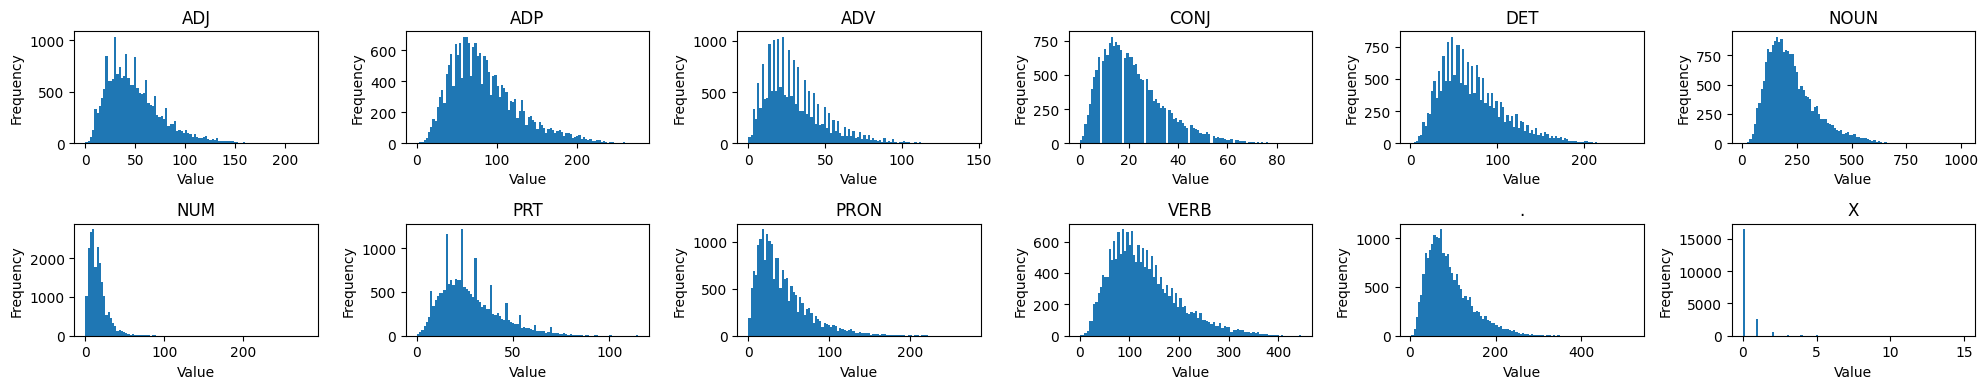

In [22]:
# Analyze POS tag distribution on the acrticle df
plot_histograms(df_article, num_rows=2, num_cols=6)

In [23]:
# Examine POS descriptive statistics on the summary df
df_article.describe()

,ADJ,ADP,ADV,CONJ,DET,NOUN,NUM,PRT,PRON,VERB,.,X
count,19985.000000,19985.000000,19985.000000,19985.000000,19985.000000,19985.000000,19985.000000,19985.000000,19985.000000,19985.000000,19985.000000,19985.000000
mean,49.371028,84.932750,30.000150,21.479259,71.603553,225.451238,15.518989,27.800701,42.460195,130.110333,92.569527,0.251589
std,27.697473,42.891433,19.279946,12.982142,37.232263,111.276569,12.147234,15.400971,32.934494,68.654764,52.397868,0.681559
min,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000
25%,29.000000,53.000000,16.000000,12.000000,44.000000,145.000000,7.000000,17.000000,19.000000,79.000000,55.000000,0.000000
50%,44.000000,77.000000,26.000000,19.000000,64.000000,203.000000,13.000000,25.000000,34.000000,117.000000,81.000000,0.000000
75%,64.000000,108.000000,40.000000,28.000000,92.000000,283.000000,20.000000,36.000000,57.000000,167.000000,119.000000,0.000000
max,222.000000,276.000000,144.000000,90.000000,256.000000,1013.000000,280.000000,115.000000,273.000000,446.000000,519.000000,15.000000


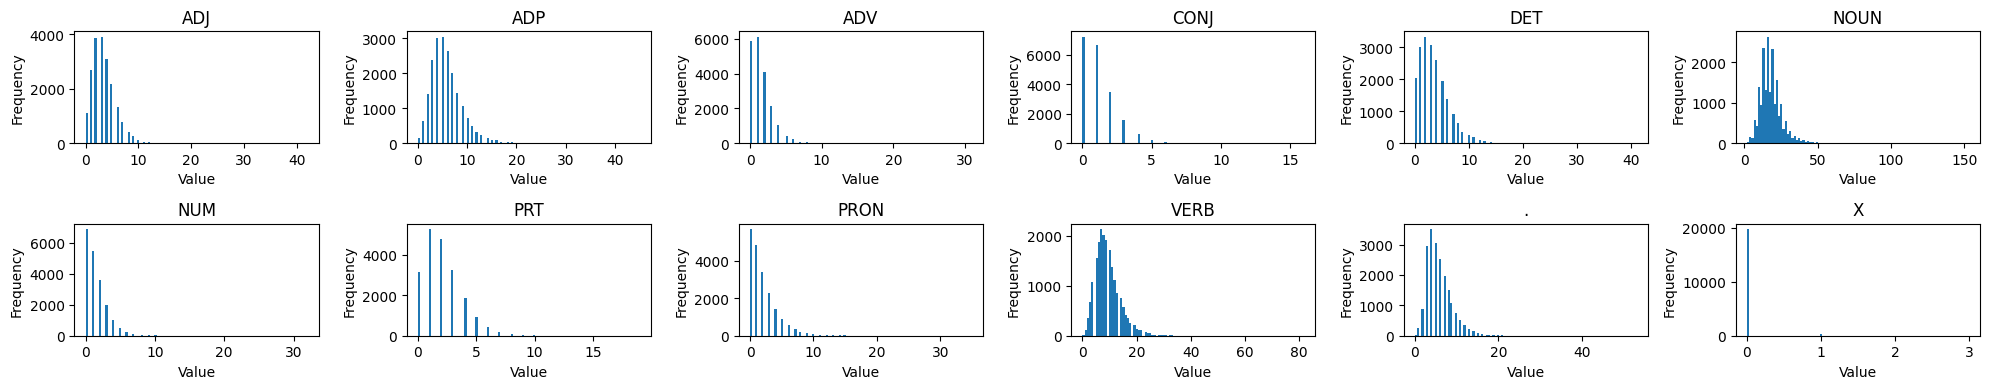

In [24]:
# Analyze POS tag distribution on the summary df
plot_histograms(df_summary, num_rows=2, num_cols=6)

## Check for Unknown Words, Symbols, Characters, and Special Characters

In [40]:
#Check for Unknown Words(names, surnames, locations or misspelled words)
def get_unique_unknown_words(tokenize_text, vocab):
    unknown_words = {word for word in tokenize_text if word.lower() not in vocab}
    return unknown_words

# Download the pre-trained GloVe word vectors
glove_vectors = api.load('glove-wiki-gigaword-100')

# Get the vocabulary of the GloVe embeddings
glove_vocab = set(glove_vectors.key_to_index.keys())

# Get unique unknown words in 'article' column
df['unknown_words_article'] = df['article'].apply(lambda x: get_unique_unknown_words(x, glove_vocab))

# Get unique unknown words in 'summary' column
df['unknown_words_summary'] = df['summary'].apply(lambda x: get_unique_unknown_words(x, glove_vocab))

# Print the unique unknown words in 'article' column
print("Unique unknown words in 'article' column:")
print(set.union(*df['unknown_words_article']))

# Print the unique unknown words in 'summary' column
print("Unique unknown words in 'summary' column:")
print(set.union(*df['unknown_words_summary']))

Unique unknown words in 'article' column:
{'₩', '−', '′', '남', '²', '�', 'ы', '타', '¹', '❤', 'さ', '分', 'Ḥ', '±', 'ย', '‡', '§', '‑', '강', '\u200f', '\u2005', '°', 'ん', '스', '\u202c', '\u2009', '⁄', ' ', '️', '¬', '‒', '•', '´', '\xad', '●', '■', 'ṣ', '\u2028', 'ń', '\xa0', '自', '÷', '¦', '¯', '→', 'º', '█', 'ù', 'ﬁ', 'ğ', '×', '♡', 'พ', '©', '\ufeff', '\u202a', 'ş', '\u200b', '®', '‐', '\u200e', 'Ş', 'ň', '˜', '³', '일', '™'}
Unique unknown words in 'summary' column:
{' ', 'º', 'ğ', '™', '©', '\u202a', '\xa0', '°', '\n', '¯', '\u2009'}


## Topic Modelling
- Topic modeling is a natural language processing technique used to discover latent patterns or topics within a collection of documents. It is an unsupervised learning approach that aims to identify groups of words (topics) that frequently occur together in the documents, providing insights into the main themes or subjects discussed in the text corpus.

In [48]:
# Initialise the count vectorizer
tf_vectorizer = CountVectorizer(max_df=0.9, min_df=25, max_features=5000)

# Apply the count vectorized method to the data
tf = tf_vectorizer.fit_transform(df['article'])

# Build the Document Term Matrix
tf_feature_names = tf_vectorizer.get_feature_names_out()
doc_term_matrix = pd.DataFrame(tf.toarray(), columns=list(tf_feature_names))

# Perform Topic Modeling using Latent Dirichlet Allocation (LDA)
num_topics = 5
lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda_output = lda_model.fit_transform(tf)

# Print the top words for each topic
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx + 1}:")
        print(", ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
        print()

n_top_words = 10
print_top_words(lda_model, tf_feature_names, n_top_words)

Topic 1:
his, he, as, has, but, by, be, will, from, have

Topic 2:
said, as, from, by, were, have, are, an, has, be

Topic 3:
he, said, his, police, by, had, who, were, not, after

Topic 4:
are, be, as, have, they, this, we, by, you, their

Topic 5:
her, he, she, his, had, as, said, but, my, when



## Visualizing the Topic Modelling Results

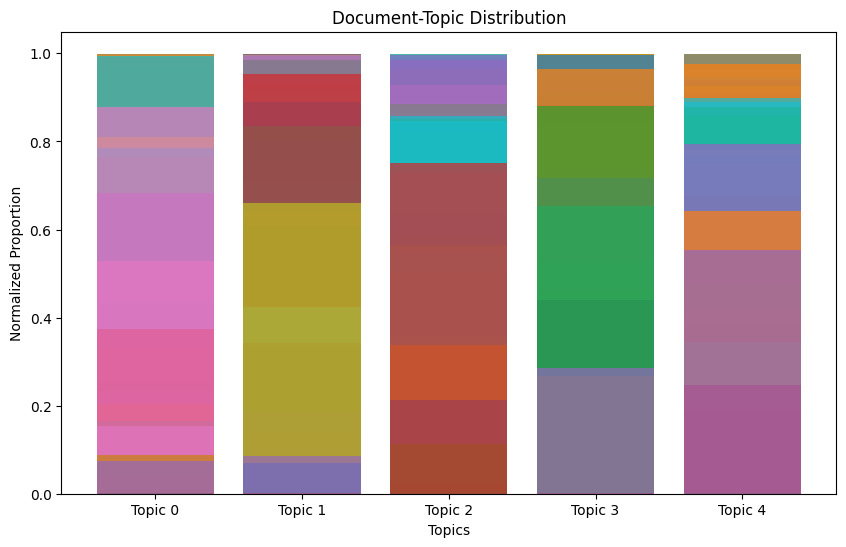

In [50]:
def plot_document_topic_distribution(model_output):
    # Normalize the document-topic distribution
    normalized_output = model_output / model_output.sum(axis=1)[:, np.newaxis]

    # Create a bar plot to visualize the document-topic distribution
    plt.figure(figsize=(10, 6))
    topics = [f'Topic {i}' for i in range(lda_model.n_components)]
    for i in range(normalized_output.shape[0]):
        plt.bar(topics, normalized_output[i], alpha=0.7)
    plt.xlabel('Topics')
    plt.ylabel('Normalized Proportion')
    plt.title('Document-Topic Distribution')
    plt.show()

# Visualize the document-topic distribution
plot_document_topic_distribution(lda_output)


<ipython-input-49-a6308e798bb8>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(top_features)


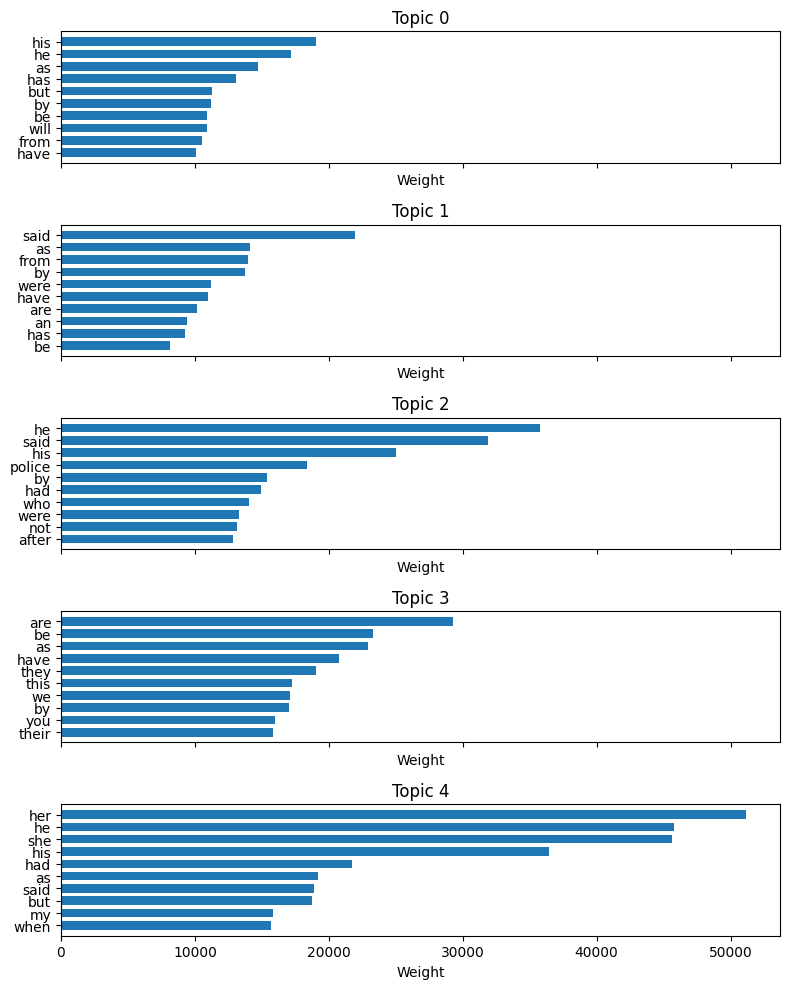

In [49]:
#Visualize the top words for each topic
def plot_top_words(model, feature_names, n_top_words):
    fig, axes = plt.subplots(nrows=model.n_components, ncols=1, figsize=(8, 2 * model.n_components),
                             sharex=True)
    for topic_idx, topic in enumerate(model.components_):
        top_features_idx = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_idx]
        weights = topic[top_features_idx]
        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_yticklabels(top_features)
        ax.invert_yaxis()
        ax.set_xlabel('Weight')
        ax.set_title(f'Topic {topic_idx}')
    plt.tight_layout()
    plt.show()

# Visualize the top words for each topic
n_top_words = 10
plot_top_words(lda_model, tf_feature_names, n_top_words)

- all news are closely related and include terms like said, he, she, you.